Seasonal Analysis

We load the extracted cases with animals and preview the initial rows to understand the structure of our data.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the data
file_path = '../Datasets/animal_cases.csv'
file_path1 = '../Datasets/boston_weather_data.csv'
data = pd.read_csv(file_path)
weather_data =pd.read_csv(file_path1)
# Display the first few rows of the dataframe
data.head()

/var/folders/k2/05jyffc934vg5tpqj7xk80mw0000gn/T/ipykernel_37818/2023322039.py:7: DtypeWarning: Columns (13,16,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,reason,...,ward,precinct,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,year,animal
0,101000295622,2011-07-01 02:44:50,2011-07-04 02:44:49,2011-07-01 02:44:55,ONTIME,Closed,Case Closed Internal Case,Pick up Dead Animal,Public Works Department,Street Cleaning,...,Ward 16,1602,305 Freeport St,2122,42.302020,-71.051911,0101000020E6100000AC4EA98052C351C098735293A826...,Employee Generated,2011,Animal
1,101000295636,2011-07-01 03:44:54,2011-07-04 03:44:53,2011-07-01 05:19:44,ONTIME,Closed,Case Closed Case Resolved Pickup Dead Animal (...,Pick up Dead Animal,Public Works Department,Street Cleaning,...,Ward 18,1801,10 Ledgebrook Rd,2126,42.270690,-71.083371,0101000020E61000009AEA0EF255C551C0821CA0F4A522...,Constituent Call,2011,Cats
2,101000295715,2011-07-01 04:40:53,2011-07-04 04:40:53,2011-07-01 05:18:50,ONTIME,Closed,Case Closed Case Resolved,Pick up Dead Animal,Public Works Department,Street Cleaning,...,Ward 2,0202,114 Sixteenth St,2129,42.379345,-71.051074,0101000020E6100000EA197ECD44C351C06EBE625C8E30...,Constituent Call,2011,Animal
3,101000295859,2011-07-01 06:51:01,2011-07-04 06:51:00,2011-07-01 06:51:08,ONTIME,Closed,Case Closed Internal Case,Pick up Dead Animal,Public Works Department,Street Cleaning,...,Ward 15,1504,10 Hendry St,2125,42.308970,-71.064861,0101000020E61000004562F4AC26C451C0B1264B508C27...,Employee Generated,2011,Animal
4,101000295903,2011-07-01 07:46:49,2011-07-04 07:46:45,2011-07-01 09:15:33,ONTIME,Closed,Case Closed Case Resolved picked up,Pick up Dead Animal,Public Works Department,Street Cleaning,...,Ward 18,1813,69 Davison St,2136,42.257640,-71.117461,0101000020E6100000F91C537A84C751C0FE88B655FA20...,Employee Generated,2011,Animal


We process the data by extracting the date information and categorizing each entry by the season in which it occurred.

In [12]:
data['open_dt'] = pd.to_datetime(data['open_dt'], errors='coerce')

data['month'] = data['open_dt'].dt.month
data['year'] = data['open_dt'].dt.year

def label_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['season'] = data['month'].apply(label_season)
data['date']=data['open_dt'].dt.date
seasonal_complaints = data.groupby(['year', 'season']).size().unstack(fill_value=0)

Visualize the data to better understand the seasonal trends in complaints.

After establishing the seasonal patterns, we proceed to analyze the distribution of complaints across individual months regardless of the year.

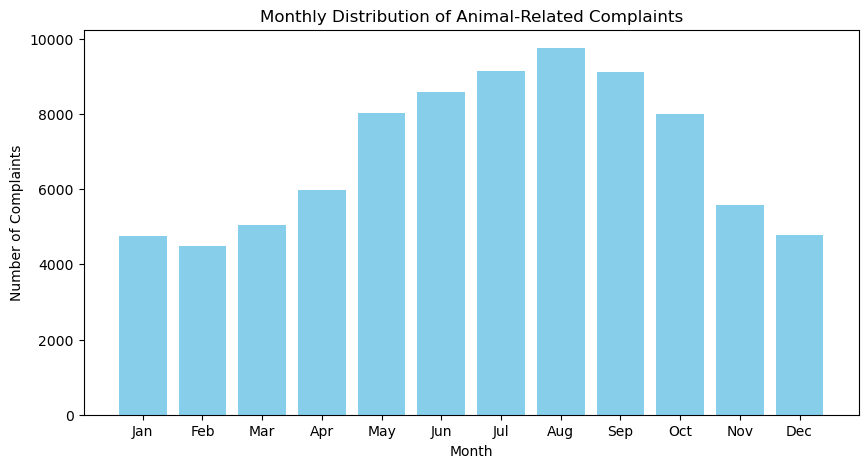

In [6]:
monthly_complaints = data.groupby(data['open_dt'].dt.month).size()

plt.figure(figsize=(10, 5))
plt.bar(monthly_complaints.index, monthly_complaints.values, color='skyblue')
plt.title('Monthly Distribution of Animal-Related Complaints')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

We also look for any patterns in the frequency of complaints on a daily basis over the entire data range.

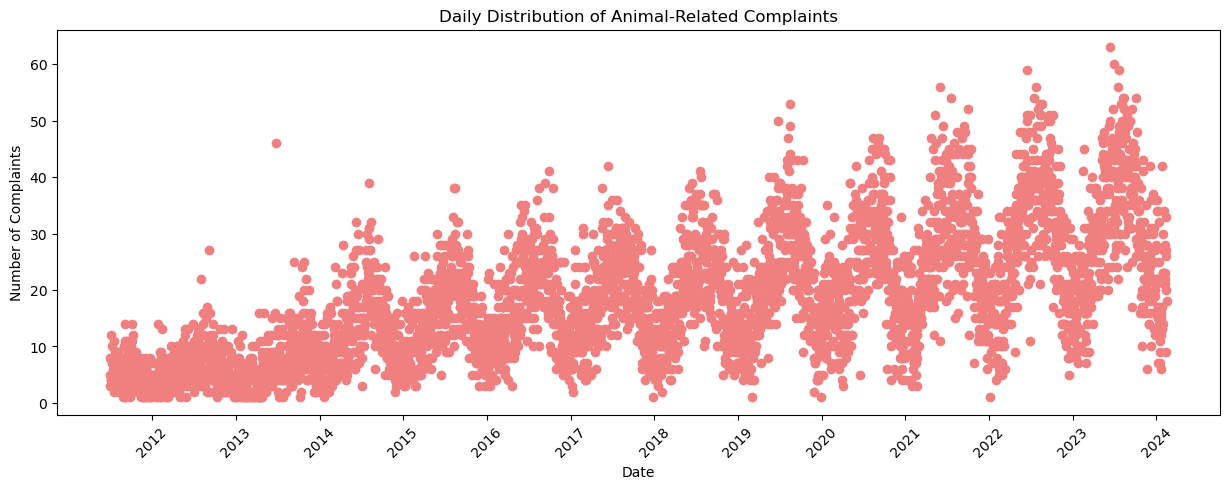

In [8]:
daily_complaints = data['open_dt'].dt.date.value_counts().sort_index()

plt.figure(figsize=(15, 5))
plt.plot(daily_complaints.index, daily_complaints.values, 'o', color='lightcoral')
plt.title('Daily Distribution of Animal-Related Complaints')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')

# Set x-axis to show each year
yearly_ticks = pd.date_range(start=daily_complaints.index.min(), end=daily_complaints.index.max(), freq='YS')
plt.xticks(yearly_ticks, [tick.strftime('%Y') for tick in yearly_ticks], rotation=45)

plt.show()

The monthly analysis reveals a peak in complaints during the summer months, with July and August having the highest number of complaints. This observation supports the seasonal trend identified earlier.

In the daily complaint analysis, the data shows peaks that consistently occur in the middle months of the year, which corresponds to the summer season, while troughs or lower frequencies of complaints appear in the edge months, notably aligning with the winter season. This pattern provides further evidence of the seasonal connection.

Given that activities tend to increase during warmer seasons, it prompts an analysis of the relationship between temperature and the number of reported cases. We've integrated historical temperature data for Boston spanning from 2013 to 2023. 

In [13]:
weather_data['tavg'] = weather_data['tavg'].fillna(method='ffill')

data['date'] = pd.to_datetime(data['open_dt']).dt.date
weather_data['time'] = pd.to_datetime(weather_data['time'])

weather_data['date'] = weather_data['time'].dt.date

combined_data = pd.merge(data, weather_data, on='date')

combined_data['case_count'] = combined_data.groupby('date')['case_enquiry_id'].transform('count')

correlation = combined_data['tavg'].corr(combined_data['case_count'])
print(f"The correlation between average temperature and case count is: {correlation}")



The correlation between average temperature and case count is: 0.5244357927292608


The calculated correlation coefficient of 0.5244357927292612 indicates a moderate positive relationship between average temperature and case count. This suggests that as temperatures rise, there is a corresponding increase in the number of cases, albeit with the understanding that temperature is likely just one of many factors influencing case counts.

After establishing a moderate correlation between temperature and case counts, we further explored the data distribution using box plots, which provided a visual summary of the variance in case counts within specific temperature bins.

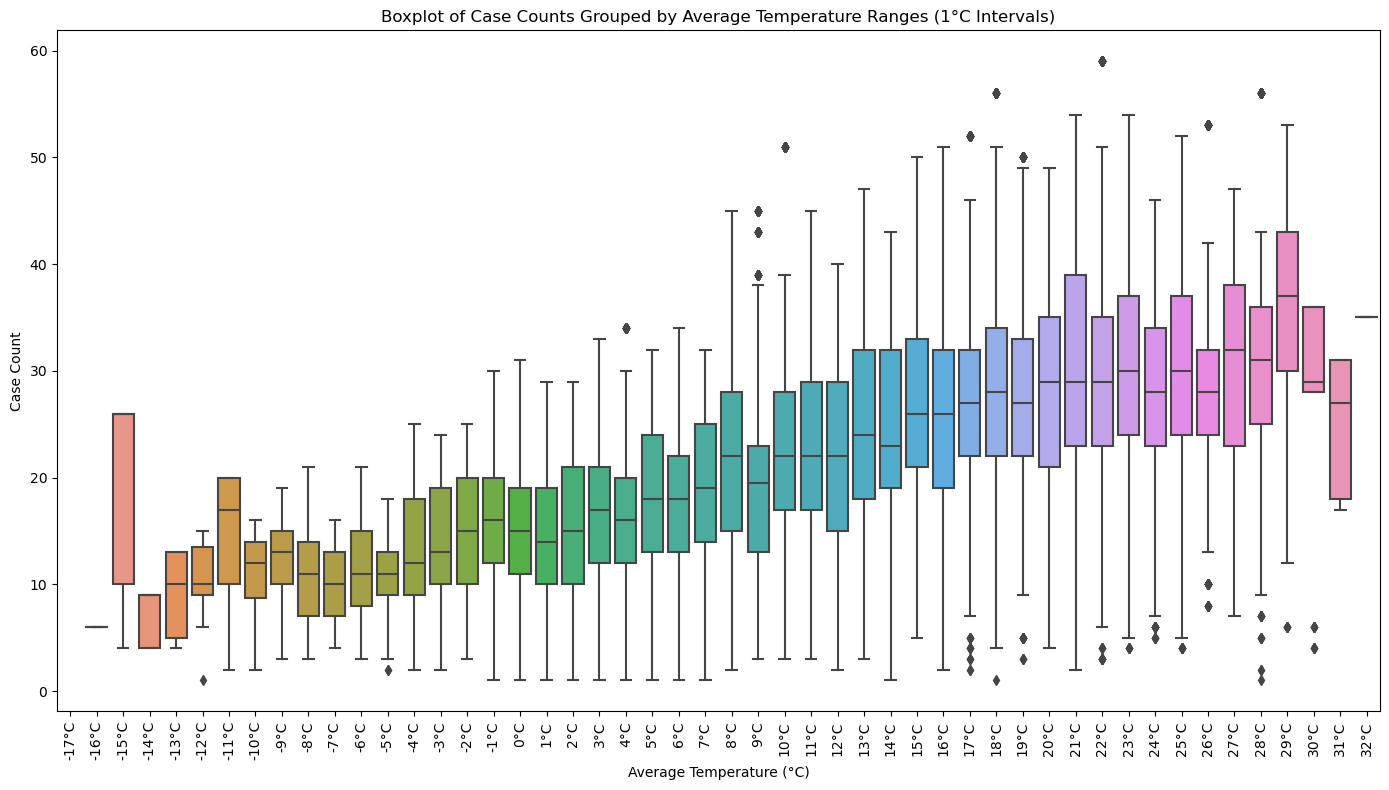

In [19]:
min_temp = int(combined_data['tavg'].min())
max_temp = int(combined_data['tavg'].max()) + 1
bin_edges = np.arange(start=min_temp, stop=max_temp + 1, step=1)
bin_labels = [f'{int(edge)}°C' for edge in bin_edges[:-1]]

combined_data['temp_bins'] = pd.cut(combined_data['tavg'], bins=bin_edges, labels=bin_labels, include_lowest=True, right=False)

# Plotting
plt.figure(figsize=(14, 8))
sns.boxplot(x='temp_bins', y='case_count', data=combined_data)
plt.xticks(rotation=90)
plt.title('Boxplot of Case Counts Grouped by Average Temperature Ranges (1°C Intervals)')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Case Count')
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

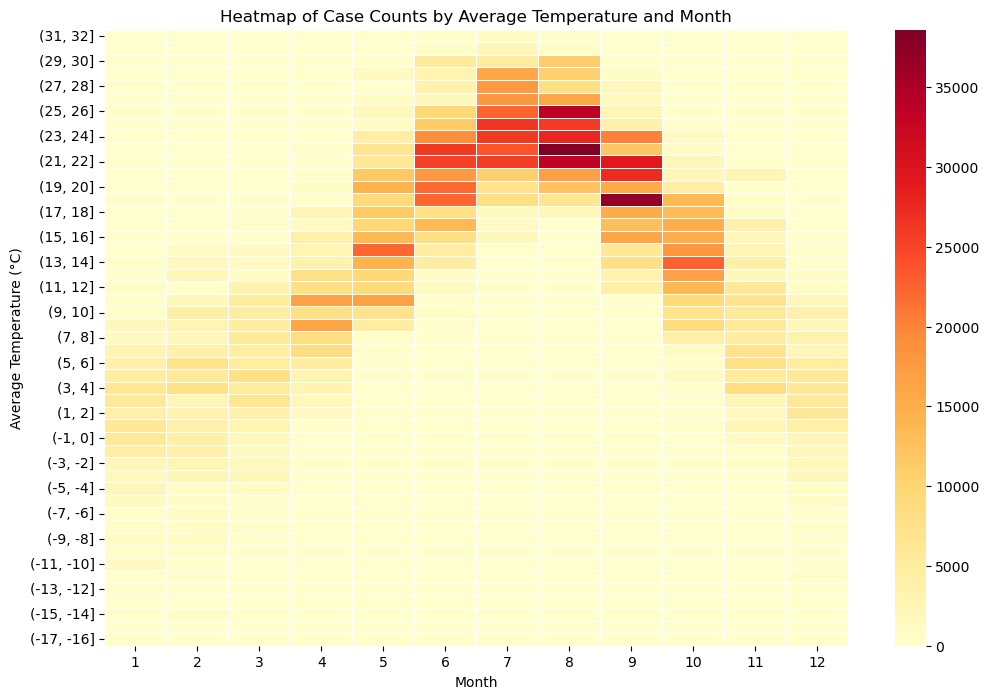

In [16]:

combined_data['date'] = pd.to_datetime(combined_data['date'])

# Create temperature bins
temp_bins = pd.cut(combined_data['tavg'], bins=range(int(combined_data['tavg'].min()), int(combined_data['tavg'].max())+1, 1))

# Create a pivot table with temperature bins as rows, months as columns, and case counts as values
pivot_table = combined_data.pivot_table(index=temp_bins, columns=combined_data['date'].dt.month, values='case_count', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(pivot_table, cmap='YlOrRd', linewidths=.5)
ax.set_title('Heatmap of Case Counts by Average Temperature and Month')
ax.invert_yaxis()  # Reverse the y-axis
ax.set_xlabel('Month')
ax.set_ylabel('Average Temperature (°C)')
plt.show()

We produced a heatmap showing the distribution of case counts across different temperature bins and months. This visualization technique helped highlight the concentration of cases in relation to temperature, offering a clear view of how case frequencies might fluctuate with seasonal temperature changes.

The moderate correlation between temperature and case counts underscores the multifaceted nature of incident reporting, which is influenced by a range of variables including but not limited to weather conditions. 